In [1]:
# https://medium.com/@financialnoob

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
stablecoin = ['BUSD', 'USDC', 'TUSD', 'USDP', 'SUSD', 'GBP', 'EUR', 'AUD']

In [26]:
df = pd.read_csv('../data/binance_daily_px.csv')
df['Date'] = pd.to_datetime(df['Date'])
# train jan-apr, test may
df.set_index(['Date'], inplace=True)
df = df.loc['2022-07-01':]#'2021-11-30']
# df.drop([coin+"USDT" for coin in stablecoin], axis=1, inplace=True)
df.dropna(axis=1, thresh=100,  inplace=True)  #thresh=100, 
print(df.shape)
df.tail()

(111, 339)


,1INCHUSDT,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,ADADOWNUSDT,ADAUPUSDT,ADAUSDT,ADXUSDT,AGLDUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-15,0.562,71.9,0.1734,0.01207,3.058,0.006466,0.557,0.3641,0.1562,0.311,...,1.355,0.00310,4.59,975.1,7542.0,0.3229,50.9,12.35,0.03018,0.2451
2022-10-16,0.569,75.8,0.1752,0.01237,3.165,0.006313,0.585,0.3703,0.1639,0.328,...,1.355,0.00324,4.64,991.3,7737.0,0.3246,51.8,12.72,0.03061,0.2511
2022-10-17,0.576,78.9,0.1731,0.01213,3.168,0.006211,0.595,0.3723,0.1583,0.322,...,1.389,0.00320,4.67,1009.0,7908.0,0.3158,52.8,13.07,0.03136,0.2550
2022-10-18,0.570,82.5,0.1660,0.01188,3.169,0.006454,0.546,0.3624,0.1560,0.311,...,1.375,0.00323,4.56,1018.0,7731.0,0.3036,52.4,12.83,0.03140,0.2531
2022-10-19,0.571,84.7,0.1672,0.01150,3.062,0.006660,0.533,0.3577,0.1577,0.311,...,1.372,0.00322,4.51,1021.2,7693.0,0.3013,52.0,12.72,0.03035,0.2517


In [29]:
# calculate cumulative returns
cum_return = np.log(df).diff().cumsum()+1 
# cum_return.dropna(thresh=150, axis=1, inplace=True)
cum_return.dropna(axis=0, how='all', inplace=True)
print(cum_return.shape)
cum_return.head()

(110, 339)


,1INCHUSDT,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,ADADOWNUSDT,ADAUPUSDT,ADAUSDT,ADXUSDT,AGLDUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-02,0.973662,1.026248,1.008811,1.002480,0.994640,0.964871,1.023399,1.015919,1.045657,0.982345,...,1.053685,1.024868,0.984930,1.111832,1.098132,0.919320,1.009302,1.036640,0.954087,0.983160
2022-07-03,0.959433,1.022788,1.017544,0.996683,1.013100,0.960293,1.023399,1.016358,1.037957,0.943430,...,1.048859,1.062738,1.008511,1.075288,1.067336,0.863345,1.018519,1.041766,0.947131,0.970088
2022-07-04,0.975231,1.112252,1.100926,1.017235,1.018362,0.886428,1.098687,1.045314,1.118270,0.979797,...,1.108548,1.131281,1.066140,1.099700,1.154115,0.886387,1.082484,1.127132,0.979937,0.985488
2022-07-05,0.949833,1.073475,1.047525,0.990017,1.007810,0.944504,1.022297,1.018548,1.089320,0.951335,...,1.063949,1.086112,1.052041,1.035680,1.119079,0.924337,1.065122,1.106122,0.955883,0.986816
2022-07-06,0.956243,1.110666,1.072526,1.000827,1.008517,0.917458,1.052702,1.029860,1.565231,1.117783,...,1.115038,1.105720,1.078068,1.045912,1.145373,0.943869,1.084204,1.151645,0.967096,1.007178


### Manual filter

In [19]:
def calculate_distances(cumret):
    '''
    calculate Euclidean distance for each pair of stocks in the dataframe
    return sorted dictionary (in ascending order)
    '''
    distances = {} # dictionary with distance for each pair
    
    # calculate distances
    for s1 in ['BTCUSDT', 'ETHUSDT']: #cumret.columns:
        for s2 in cumret.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in distances.keys()) and (f'{s2}-{s1}' not in distances.keys()):
                dist = np.sqrt(np.sum((cumret[s1] - cumret[s2])**2)) # Euclidean distance
                distances[f'{s1}-{s2}'] = dist
    
    # sort dictionary
    sorted_distances = {k:v for k,v in sorted(distances.items(), key = lambda item: item[1])}
    return sorted_distances

def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]
    
    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint
    
    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]
    
    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]
    
    return halflife

def select_pairs(sorted_distances, cumret, N=5, test=False, ml=False):
    '''
    calculate metrics for N pairs with the smallest Euclidean distance
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    
    pairs = [k for k,v in sorted_distances.items()][:N]
    cols = ['Euclidean distance', 'ADF p-value', 'Spread SD', '% days within 2-SD band', 
        'Hurst Exponent', 'Half-life of mean reversion']
    if test:
        cols.remove('Hurst Exponent')
    cols += ['Num zero-crossings']
    results = pd.DataFrame(index=pairs, columns=cols)
    for pair in pairs:
        print(pair)
        s1,s2 = parse_pair(pair)
        # hedge_ratio = pairs_df.loc[pair]['Hedge ratio']
        spread = cumret[s1] - cumret[s2]
        results.loc[pair]['Euclidean distance'] = np.sqrt(np.sum((spread)**2))
        results.loc[pair]['CADF p-value'] = cadf_pvalue(s1, s2, cumret)
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        results.loc[pair]['Spread SD'] = spread.std()
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        results.loc[pair]['% days within 2-SD band'] = (abs(spread) < 2*spread.std()).sum() / len(spread) * 100
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0]
        if test is False:
            results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]   
        results.loc[pair]['Num zero-crossings'] = ((spread[1:].values * spread[:-1].values) < 0).sum()
        
    #when formation period is 6 months
    # if test is False:
    #     results = results[results['Hurst Exponent'] <= 0.5]
    # results = results[results['ADF p-value'] <= 0.1]
    # results = results[results['Spread SD'] >= 0.08]
    # results = results[results['% days within 2-SD band'] >= 90]
    # results = results[results['Num zero-crossings'] >= 10]
    # results = results[results['Half-life of mean reversion'] <= 20]
    
    # when formation period is 3 months
    # if test is False:
    #     results = results[results['Hurst Exponent'] <= 0.5]
    # results = results[results['ADF p-value'] <= 0.05]
    # results = results[results['Spread SD'] >= 0.1]
    # results = results[results['% days within 2-SD band'] >= 90]
    # results = results[results['Num zero-crossings'] >= 5]
    # results = results[results['Half-life of mean reversion'] <= 10]
    return results

def plot_pairs(sorted_distances, cumret_train, cumret_test, N=2, test=False):
    '''
    plot cumulative returns of the spread for each of N pairs with smallest Euclidean distance
    '''
    if test:
        pairs = sorted_distances
    else:
        pairs = [k for k,v in sorted_distances.items()][:N]
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread_train = cumret_train[s1] - cumret_train[s2]
        spread_test = cumret_test[s1] - cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

In [31]:
# 6m form, 3m trade
# train_start = '2022-01-01'
# train_end = '2022-06-30'
# test_start = '2022-07-01'
# test_end = '2022-10-19'

# 3m form, 1m trade
# train_start = '2022-01-01'
# train_end = '2022-03-31'
# test_start = '2022-04-01'
# test_end = '2022-04-30'

# 3m form, 3m trade
train_start = '2022-07-01'
train_end = '2022-08-30'
test_start = '2022-09-30'
test_end = '2022-10-31'

In [32]:
train_df = cum_return.loc[train_start:train_end] # formation period
train_df = train_df.dropna(axis=1) #thresh=300, 
print(train_df.shape)
test_df = cum_return.loc[test_start:test_end] # trading period
test_df = test_df.dropna(axis=1)
print(test_df.shape)

# insample_df = cum_return.dropna(axis=1)
# print(insample_df.shape)

(60, 339)
(20, 337)


In [33]:
sorted_distance_train = calculate_distances(train_df)
sorted_distance_test = calculate_distances(test_df)
# sorted_distance_insample = calculate_distances(insample_df)

In [34]:
filtered_pairs = select_pairs(sorted_distance_train, train_df, N=20, test=True)
# filtered_pairs = select_pairs(sorted_distance_insample, insample_df, N=20, test=True)
filtered_pairs

BTCUSDT-FTTUSDT
BTCUSDT-XRPUSDT
BTCUSDT-BTTCUSDT
BTCUSDT-OXTUSDT
BTCUSDT-HBARUSDT
BTCUSDT-COCOSUSDT
BTCUSDT-IDEXUSDT
BTCUSDT-LTOUSDT
BTCUSDT-XNOUSDT
BTCUSDT-DASHUSDT
BTCUSDT-JSTUSDT
BTCUSDT-UTKUSDT
BTCUSDT-SCUSDT
BTCUSDT-IOTAUSDT
BTCUSDT-AUTOUSDT
BTCUSDT-TLMUSDT
BTCUSDT-DREPUSDT
BTCUSDT-PHAUSDT
BTCUSDT-LTCUSDT
BTCUSDT-TRXUPUSDT


,Euclidean distance,ADF p-value,Spread SD,% days within 2-SD band,Half-life of mean reversion,Num zero-crossings
BTCUSDT-FTTUSDT,0.166718,0.028141,0.020489,95.0,2.095801,20
BTCUSDT-XRPUSDT,0.187884,0.025789,0.019603,88.333333,2.335615,10
BTCUSDT-BTTCUSDT,0.208209,0.17129,0.026522,91.666667,3.29303,14
BTCUSDT-OXTUSDT,0.239056,0.000288,0.024839,88.333333,1.40899,11
BTCUSDT-HBARUSDT,0.26555,0.017591,0.032011,96.666667,2.317534,13
BTCUSDT-COCOSUSDT,0.275656,0.049724,0.032895,96.666667,2.815727,9
BTCUSDT-IDEXUSDT,0.285049,0.041404,0.037049,93.333333,1.925137,17
BTCUSDT-LTOUSDT,0.285053,0.006159,0.037075,98.333333,1.893789,14
BTCUSDT-XNOUSDT,0.286776,0.086894,0.031479,86.666667,3.022815,13
BTCUSDT-DASHUSDT,0.28734,0.120803,0.036289,95.0,3.313336,12


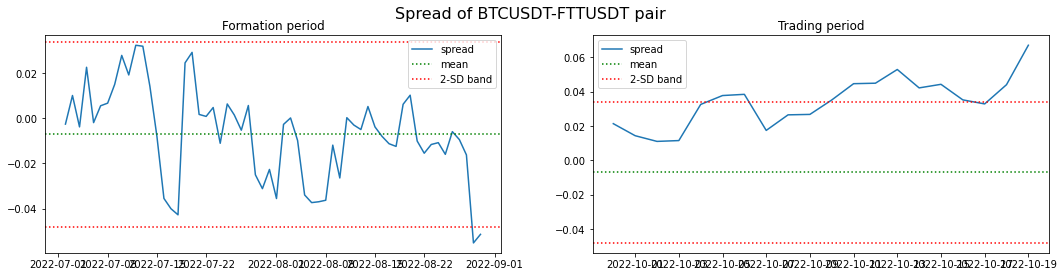

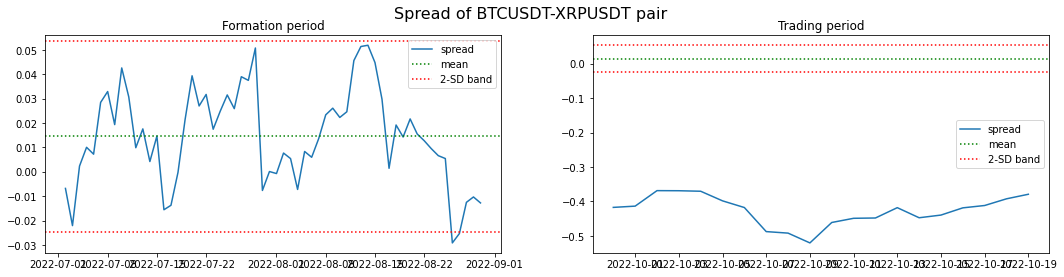

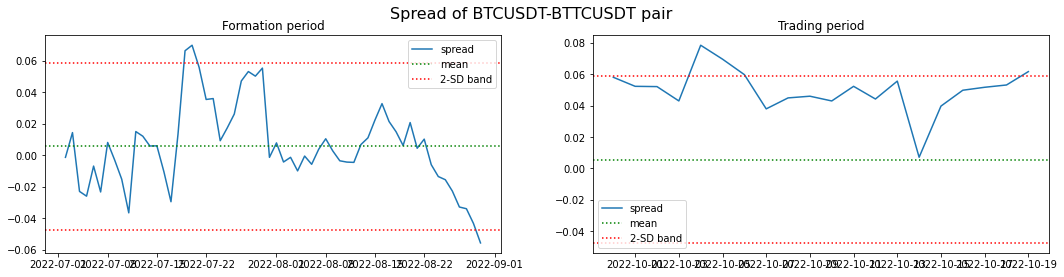

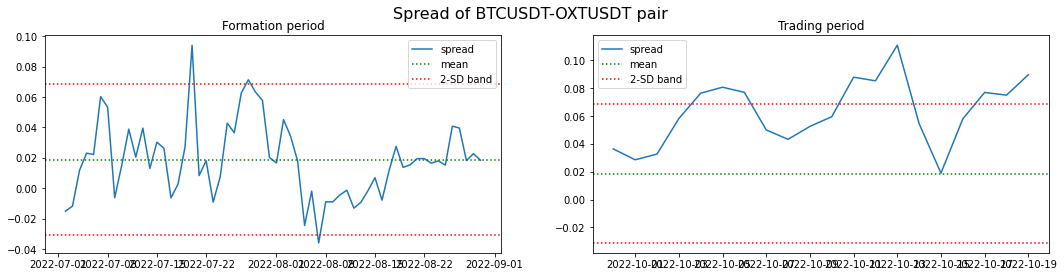

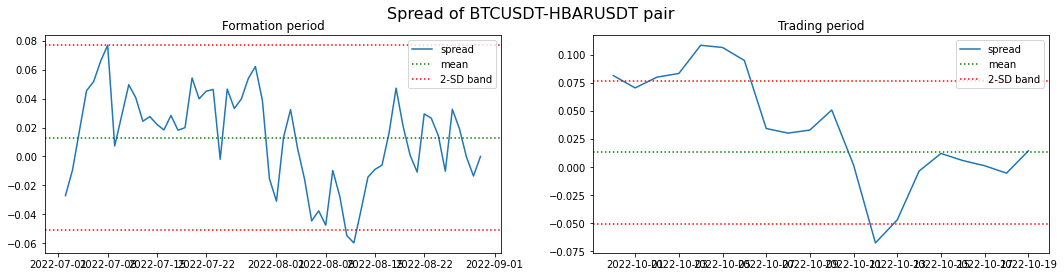

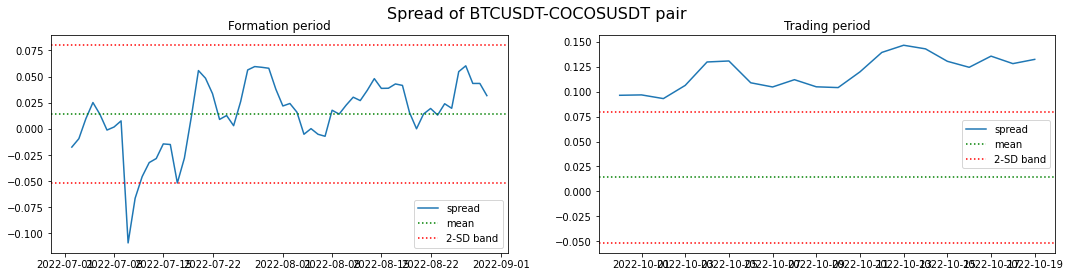

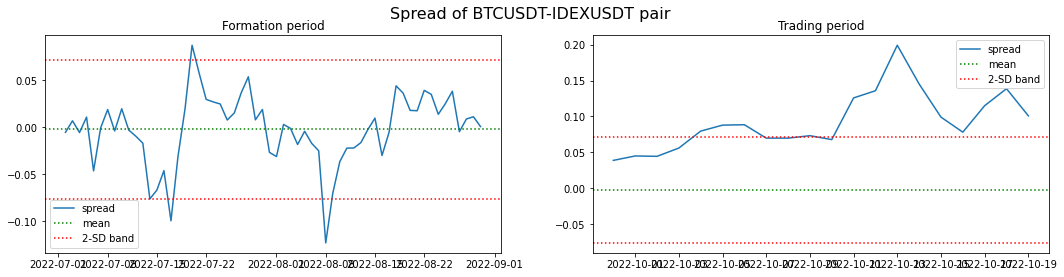

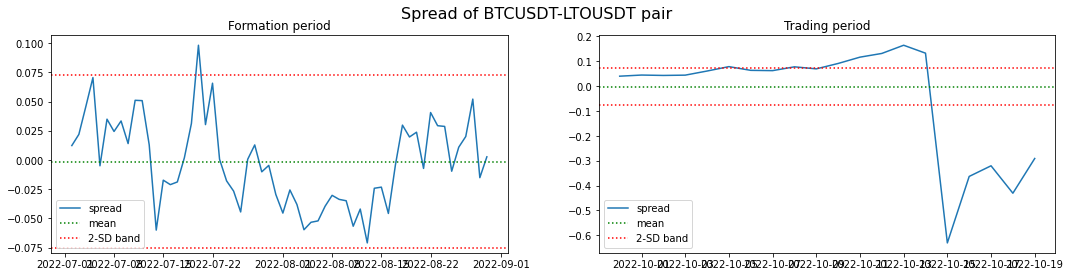

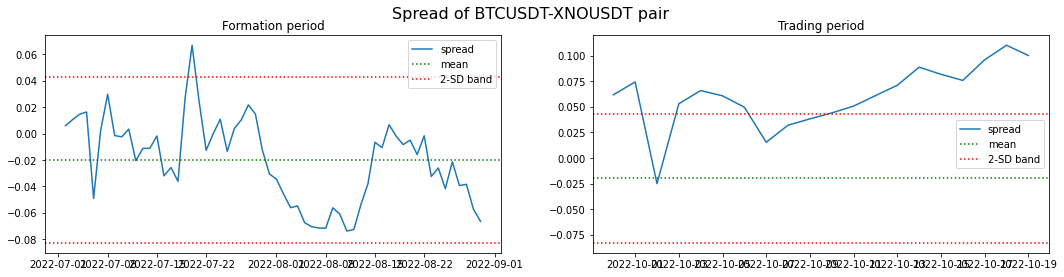

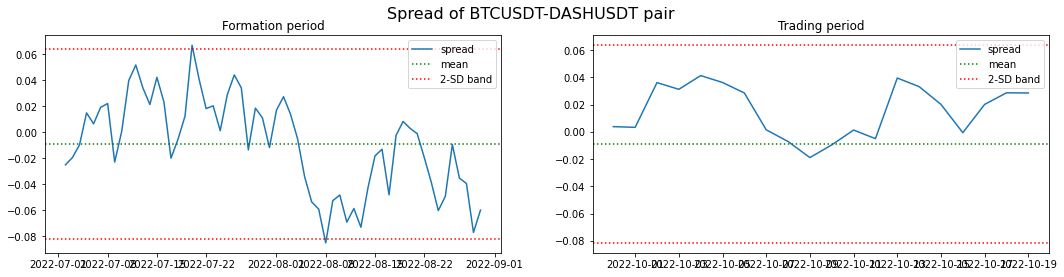

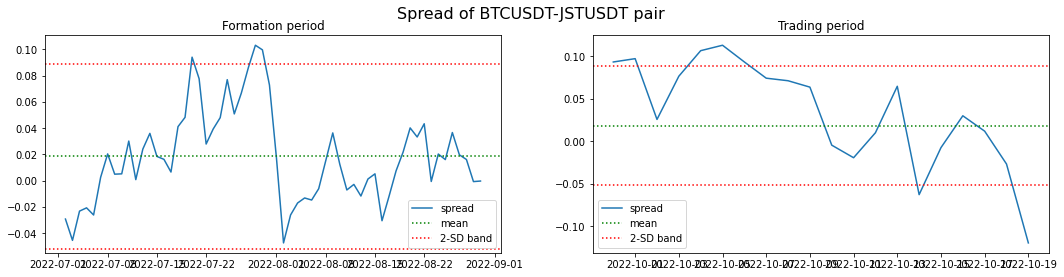

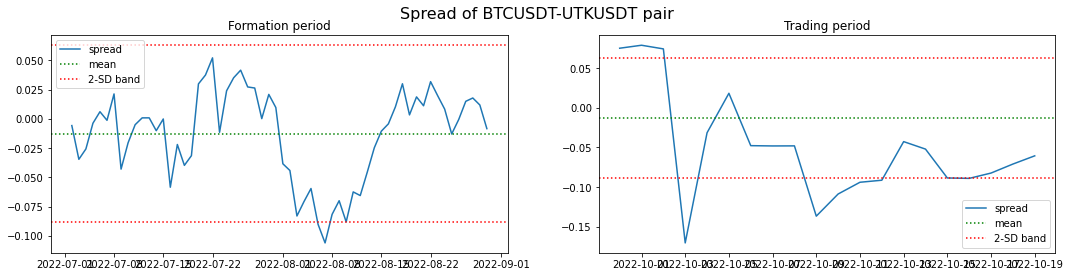

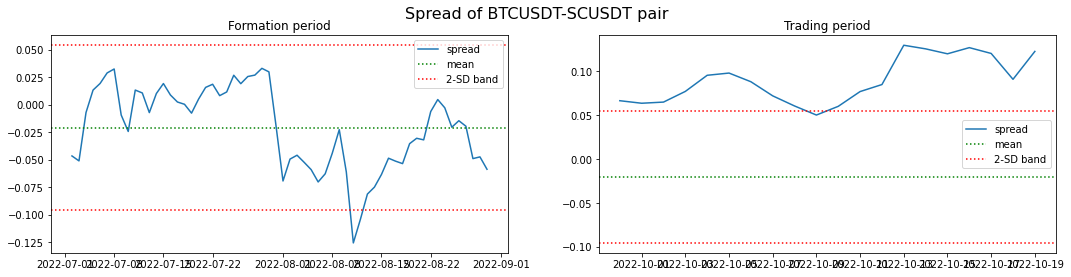

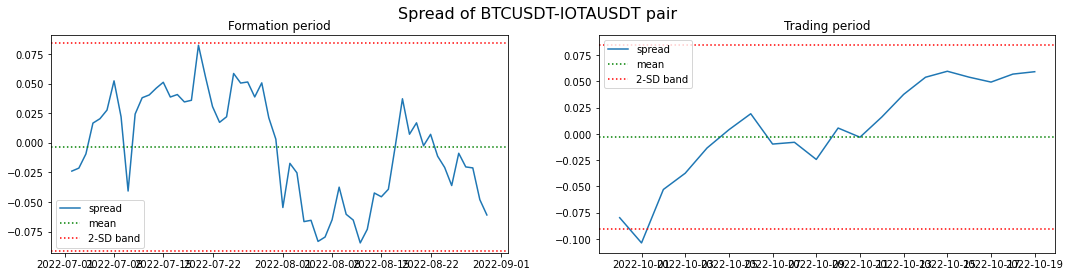

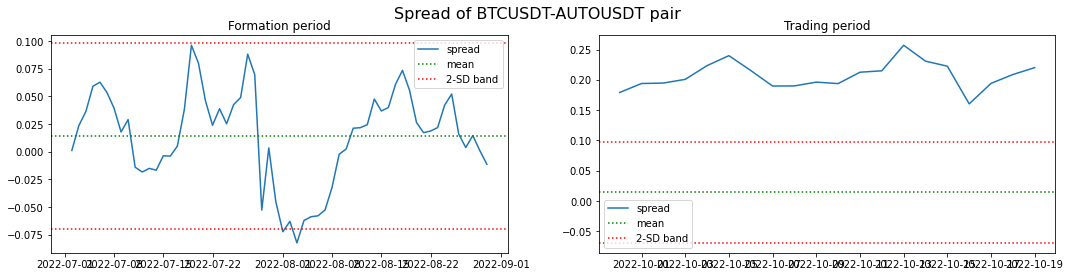

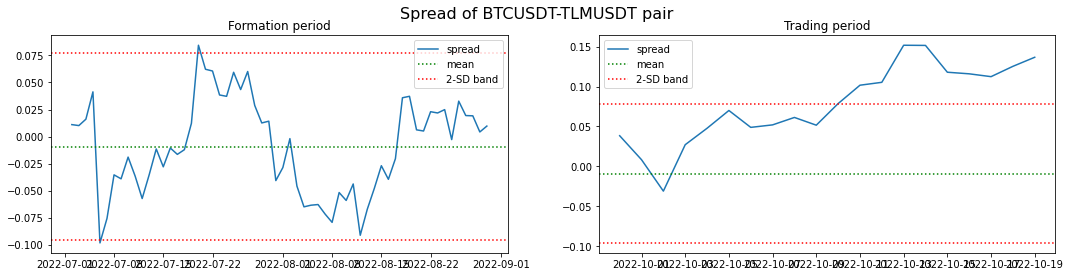

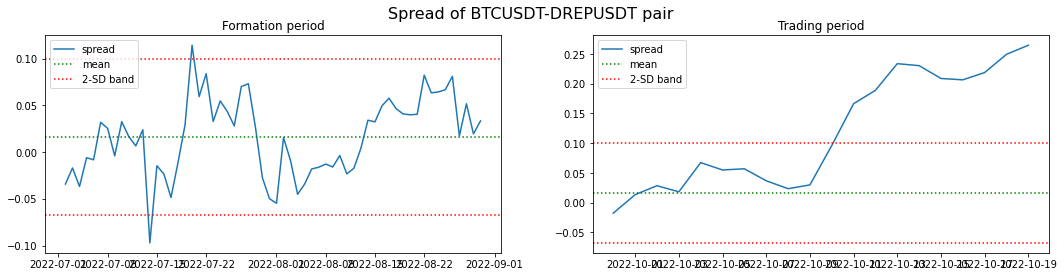

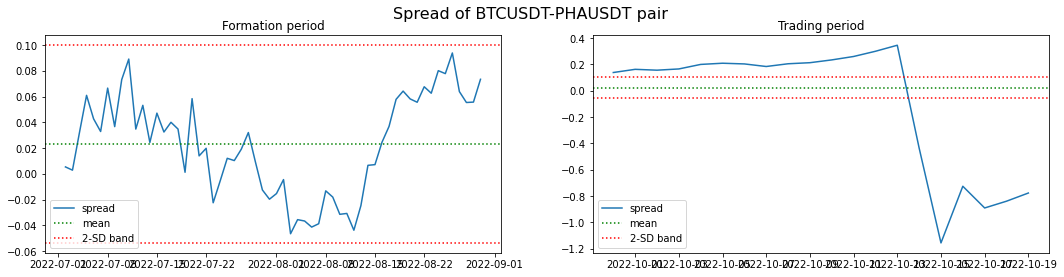

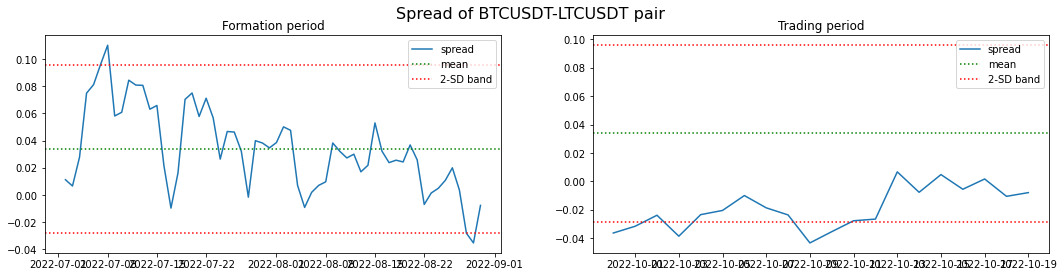

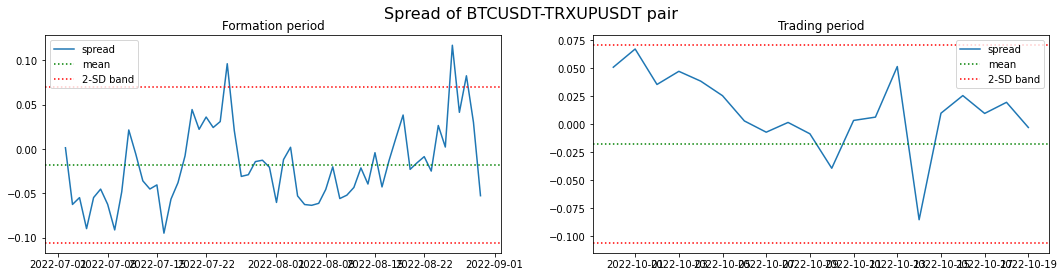

In [35]:
plot_pairs(list(filtered_pairs.index), train_df, test_df, test=True)

## Machine Learning

In [36]:
print(train_df.shape)
print(test_df.shape)

(60, 339)
(20, 337)


In [37]:
def train_pairs(sorted_distances, cumret, N=3, test=False, ml=False):
    '''
    calculate metrics for N pairs with the smallest Euclidean distance
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    
    pairs = [k for k,v in sorted_distances.items()][:N]
    cols = ['Euclidean distance', 'CADF p-value', 'ADF p-value', 'Spread SD', '% days within 2-SD band', 
        'Hurst Exponent', 'Half-life of mean reversion', 'Pearson r']
    if test:
        cols.remove('Hurst Exponent')
    cols += ['Num zero-crossings']
    results = pd.DataFrame(index=pairs, columns=cols)
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        # hedge_ratio = pairs_df.loc[pair]['Hedge ratio']
        spread = cumret[s1] - cumret[s2]
        results.loc[pair]['Euclidean distance'] = np.sqrt(np.sum((spread)**2))
        results.loc[pair]['CADF p-value'] = cadf_pvalue(s1, s2, cumret)
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        results.loc[pair]['Spread SD'] = spread.std()
        results.loc[pair]['% days within 2-SD band'] = (abs(spread) < 2*spread.std()).sum() / len(spread) * 100
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        if test is False:
            results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]   
        results.loc[pair]['Num zero-crossings'] = ((spread[1:].values * spread[:-1].values) < 0).sum()
    return results

In [38]:
train_data = train_pairs(sorted_distance_train, train_df, N=200, test=True)
test_data = train_pairs(sorted_distance_test, test_df, N=200, test=True)

In [39]:
train_data.sort_values(['Num zero-crossings'], ascending=False).head()

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,% days within 2-SD band,Half-life of mean reversion,Pearson r,Num zero-crossings
BTCUSDT-FTTUSDT,0.166718,0.075229,0.028141,0.020489,95.0,2.095801,0.964565,20
BTCUSDT-IDEXUSDT,0.285049,0.036573,0.041404,0.037049,93.333333,1.925137,0.883295,17
BTCUSDT-BLZUSDT,0.820054,0.010474,0.005003,0.106727,93.333333,4.241344,0.325176,15
BTCUSDT-UTKUSDT,0.307381,0.185592,0.09988,0.037856,91.666667,3.346012,0.912779,14
BTCUSDT-BTTCUSDT,0.208209,0.223632,0.17129,0.026522,91.666667,3.29303,0.926747,14


In [40]:
idx = 7
X_train = train_data.values[:,:idx]
X_test = test_data.values[:,:idx]
y_train = train_data.values[:,idx]
y_test = test_data.values[:,idx]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(200, 7) (200, 7)
(200,) (200,)


In [43]:
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [44]:
thresh=6
len(y_train[y_train>thresh]) / len(y_train)

0.46

In [45]:
# binarize dependent variable
binarizer = Binarizer(threshold=thresh).fit(y_train.reshape(-1,1))
y_train_bin = binarizer.transform(y_train.reshape(-1,1))
binarizer = Binarizer(threshold=6).fit(y_test.reshape(-1,1))
y_test_bin = binarizer.transform(y_test.reshape(-1,1))

In [46]:
def top10_accuracy(estimator, X, y, n=10):
    '''
    compute accuracy of top 10 predictions:
    select top 10 samples with the highest probability of belonging to class 1
    return the fraction of samples actually belonging to class1
    '''
    pred_prob = estimator.predict_proba(X)
    top10_ind = np.argsort(pred_prob[:,1])[-n:]
    score = sum(y[top10_ind] == np.ones(n))/n
    return score

In [47]:
def test_models_class(models, X=X_train, y=y_train_bin.flatten(), n_folds=3, scoring=top10_accuracy, seed=45):
    '''
    cross-validate each model in models using n_folds and scoring
    '''
    results = []
    names = []
    for name,model in models:
        kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
    return results, names

In [48]:
models = []
models.append(('LR', LogisticRegressionCV(max_iter=1000, class_weight='balanced', scoring=top10_accuracy)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA_1', QuadraticDiscriminantAnalysis()))
models.append(('QDA_2', QuadraticDiscriminantAnalysis(reg_param=0.1)))
models.append(('KNN_1', KNeighborsClassifier()))
models.append(('KNN_2', KNeighborsClassifier(weights='distance')))
models.append(('CART_1', DecisionTreeClassifier(class_weight='balanced')))
models.append(('CART_2', DecisionTreeClassifier(max_features='auto', class_weight='balanced')))
models.append(('NB', GaussianNB()))
models.append(('GPC', GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1)))
models.append(('MLP_1', MLPClassifier(max_iter=5000)))
models.append(('MLP_2', MLPClassifier(alpha=1, max_iter=5000)))
models.append(('SVM', SVC(class_weight='balanced', probability=True)))

results,names = test_models_class(models)

LR: 0.7000000000000001 (0.08164965809277262)
LDA: 0.6333333333333333 (0.09428090415820632)
QDA_1: 0.8333333333333334 (0.09428090415820636)
QDA_2: 0.8000000000000002 (0.08164965809277264)
KNN_1: 0.7666666666666666 (0.09428090415820636)
KNN_2: 0.6 (0.08164965809277258)
CART_1: 0.5 (0.14142135623730948)
CART_2: 0.43333333333333335 (0.04714045207910316)
NB: 0.8000000000000002 (0.16329931618554522)


/Users/natalieng/opt/anaconda3/envs/master/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalieng/opt/anaconda3/envs/master/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalieng/opt/anaconda3/envs/master/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


GPC: 0.7666666666666666 (0.04714045207910321)
MLP_1: 0.6333333333333333 (0.20548046676563253)
MLP_2: 0.8000000000000002 (0.08164965809277264)
SVM: 0.6 (0.08164965809277258)


In [49]:
# model = SVC(class_weight='balanced', probability=True) # 0.7, 0.6
# model = LogisticRegressionCV(max_iter=1000, 
#                              class_weight='balanced', scoring=top10_accuracy)  # 0.5, 0.7
model = LinearDiscriminantAnalysis()  # 0.8, 0.8
# model = GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1) # 1.0, 0.5
# model = GaussianNB()  # 0.8, 0.7
# model = MLPClassifier(alpha=1, max_iter=5000) # 0.8, 0.9
model.fit(X_train, y_train_bin.flatten())
print(top10_accuracy(model, X_train, y_train_bin.flatten()))
print(top10_accuracy(model, X_test, y_test_bin.flatten()))

0.8
0.0


In [51]:
model = LinearDiscriminantAnalysis(solver='svd',n_components=1,store_covariance=True)  # 0.8, 0.8
model.fit(X_train, y_train_bin.flatten())
print(top10_accuracy(model, X_train, y_train_bin.flatten()))
print(top10_accuracy(model, X_test, y_test_bin.flatten()))

0.8
0.0


In [52]:
pred_prob = model.predict_proba(X_test) # predict probabilities
# select top 10 pairs with highest probability of belonging to class 1 (sort in descending order)
top10_ind = np.argsort(pred_prob[:,1])[-10:][::-1] 
df = test_data.iloc[top10_ind,:] # show data
df.sort_values(['Half-life of mean reversion'])

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,% days within 2-SD band,Half-life of mean reversion,Pearson r,Num zero-crossings
BTCUSDT-VETUSDT,0.131811,0.9859,0.001719,0.006408,0.0,0.662192,0.936664,0
ETHUSDT-LINKUPUSDT,0.312438,0.9859,0.314365,0.065598,95.0,2.68824,0.846008,3
BTCUSDT-BAKEUSDT,0.215451,0.9859,0.0,0.042295,90.0,3.173285,0.711052,3
BTCUSDT-LINAUSDT,0.347928,0.9859,0.988999,0.078857,100.0,3.679014,0.792209,2
ETHUSDT-COTIUSDT,0.410499,0.9859,0.407043,0.069961,85.0,4.449926,0.688443,2
BTCUSDT-OOKIUSDT,0.386419,0.9859,0.0,0.069483,85.0,4.607334,0.552165,4
BTCUSDT-XVSUSDT,0.256461,0.9859,0.009229,0.047827,90.0,10.775311,0.689565,1
ETHUSDT-PSGUSDT,0.389659,0.9859,0.807836,0.089077,100.0,11.828814,0.583632,1
ETHUSDT-ACMUSDT,0.360413,0.9859,0.848648,0.081834,100.0,13.241271,0.609038,1
ETHUSDT-JUVUSDT,0.477329,0.9859,0.732923,0.109329,100.0,109.52013,0.576296,1
